In [10]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

# Data Cleaning and Reformatting

In [11]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [12]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa
import matplotlib.pyplot as plt

In [13]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    
    if os.path.isdir(actor_path) and actor.startswith("Actor_"):
        actor_number = actor.split("_")[-1]

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")
                formatted_filename = f"Actor_{actor_number}_{file}"
                data.append({"emotion": emotion, "file_path": formatted_filename})

df = pd.DataFrame(data)

print(df)

      emotion                          file_path
0       angry  Actor_16_03-01-05-01-02-01-16.wav
1     fearful  Actor_16_03-01-06-01-02-02-16.wav
2     fearful  Actor_16_03-01-06-02-01-02-16.wav
3       angry  Actor_16_03-01-05-02-01-01-16.wav
4     disgust  Actor_16_03-01-07-01-01-01-16.wav
...       ...                                ...
1435    happy  Actor_08_03-01-03-02-02-02-08.wav
1436    happy  Actor_08_03-01-03-01-01-02-08.wav
1437     calm  Actor_08_03-01-02-02-01-01-08.wav
1438     calm  Actor_08_03-01-02-01-02-01-08.wav
1439  neutral  Actor_08_03-01-01-01-02-02-08.wav

[1440 rows x 2 columns]


In [14]:
#remove calm emotion
df = df[df.emotion != 'calm']

# Extracting waveforms and spectograms

In [15]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(42)

def plot_waveform(waveform, sr, title=None, ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [16]:
def pull_wave_and_spec():
    base_dir = "data/ravdess-emotional-speech-audio/versions/1"
    output_dir = "speech"

    for actor in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor)
        if os.path.isdir(actor_path) and actor.startswith("Actor_"):
            actor_num = int(actor.split("_")[1])
            if actor_num > 22: # change actor number here because it keeps crashing midway
                print(f"Processing {actor}...")
                for file in os.listdir(actor_path):
                    if file.endswith(".wav"):
                        SAMPLE_SPEECH = os.path.join(actor_path, file)
                        SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

                        # Define transform
                        spectrogram = T.Spectrogram(n_fft=512)

                        # Perform transform
                        spec = spectrogram(SPEECH_WAVEFORM)
                        
                        fig, ax = plt.subplots()
                        plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title=None, ax=ax)
                        waveform_path = os.path.join(output_dir, f"{actor}_{file}_waveform.png")
                        plt.savefig(waveform_path)
                        plt.close(fig)

                        # Create figure for spectrogram
                        fig, ax = plt.subplots()
                        plot_spectrogram(spec[0], title=None, ax=ax)
                        spectrogram_path = os.path.join(output_dir, f"{actor}_{file}_spectrogram.png")
                        plt.savefig(spectrogram_path)
                        plt.close(fig)

# Connecting speech waveforms and spectogram to pd dataframe

In [17]:
import torchvision.transforms as transforms
from PIL import Image

# Define base path for spectrogram images
image_dir = "speech"  # Directory where spectrogram images are stored

# Define transformations (convert images to tensors)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization (optional)
])

# Function to load spectrogram as tensor
def load_spectrogram_tensor(file_path):
    filename = os.path.basename(file_path)
    spectrogram_img_path = os.path.join(image_dir, f"{filename}_spectrogram.png")  # Construct spectrogram path
    
    # Load image if it exists, else return None
    if os.path.exists(spectrogram_img_path):
        image = Image.open(spectrogram_img_path).convert("L")  # Convert to grayscale
        return transform(image)  # Convert to tensor
    return None  # If file doesn't exist, return None

# Apply function to extract spectrogram tensors
df["spectrogram_tensor"] = df["file_path"].apply(load_spectrogram_tensor)

# Display updated DataFrame
print(df.head())


   emotion                          file_path  \
0    angry  Actor_16_03-01-05-01-02-01-16.wav   
1  fearful  Actor_16_03-01-06-01-02-02-16.wav   
2  fearful  Actor_16_03-01-06-02-01-02-16.wav   
3    angry  Actor_16_03-01-05-02-01-01-16.wav   
4  disgust  Actor_16_03-01-07-01-01-01-16.wav   

                                  spectrogram_tensor  
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  


In [18]:
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd

# Define base path for waveform images
image_dir = "speech"  # Directory where waveform images are stored

# Define transformations (convert images to tensors)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization (optional)
])

# Function to load waveform as tensor
def load_waveform_tensor(file_path):
    filename = os.path.basename(file_path)  # Extract filename (e.g., "Actor_01_03-01-01-01-01-01-01.wav")
    waveform_img_path = os.path.join(image_dir, f"{filename}_waveform.png")  # Construct waveform path
    
    # Load image if it exists, else return None
    if os.path.exists(waveform_img_path):
        image = Image.open(waveform_img_path).convert("L")  # Convert to grayscale
        return transform(image)  # Convert to tensor
    return None  # If file doesn't exist, return None

# Apply function to extract waveform tensors
df["waveform_tensor"] = df["file_path"].apply(load_waveform_tensor)

# Display updated DataFrame
print(df.head())

   emotion                          file_path  \
0    angry  Actor_16_03-01-05-01-02-01-16.wav   
1  fearful  Actor_16_03-01-06-01-02-02-16.wav   
2  fearful  Actor_16_03-01-06-02-01-02-16.wav   
3    angry  Actor_16_03-01-05-02-01-01-16.wav   
4  disgust  Actor_16_03-01-07-01-01-01-16.wav   

                                  spectrogram_tensor  \
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...   

                                     waveform_tensor  
0  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
1  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
2  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
3  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  
4  [[[tensor(1.), tensor(1.), tensor(1.), tensor(...  


# Creating the model

In [19]:
print(df.iloc[0, 2].shape)
print(df.iloc[0, 3].shape)

#combined = torch.cat([tensor1, tensor2], dim=0)

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])


In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
torch.manual_seed(42);

In [21]:
len(train_df)

998

In [22]:
train_df.iloc[0]['spectrogram_tensor']

emotion_to_num = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

train_set = []
test_set = []

#create train set 
for i in range(len(train_df)):
  #concat the spectogram and waveform tensors into one 
  combined = torch.cat([train_df.iloc[i]['spectrogram_tensor'], train_df.iloc[i]['waveform_tensor']], dim=0)
  label_tensor = torch.tensor(emotion_to_num[train_df.iloc[i]['emotion']], dtype=torch.long)
  #save to dataset 
  train_set.append((combined, label_tensor))

#create test set 
for i in range(len(test_df)):
  #concat the spectogram and waveform tensors into one 
  combined = torch.cat([test_df.iloc[i]['spectrogram_tensor'], test_df.iloc[i]['waveform_tensor']], dim=0)
  label_tensor = torch.tensor(emotion_to_num[test_df.iloc[i]['emotion']], dtype=torch.long)
  test_set.append((combined, label_tensor))
  

In [32]:
BATCH_SIZE = 32  # <-- Please change this as necessary
NUM_WORKERS = 0  # <-- Use more workers for more CPU threads

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)  # (16, 480, 640)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (16, 240, 320)
        self.fc1 = nn.Linear(16 * 240 * 320, 128)  # Hidden layer
        self.fc2 = nn.Linear(128, 7)  # Output layer for 7 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv + ReLU + Pooling
        x = torch.flatten(x, start_dim=1)  # Flatten for the FC layer
        x = F.relu(self.fc1(x))  # Hidden layer
        x = self.fc2(x)  # Output logits (no softmax needed before CrossEntropyLoss)
        return x


In [24]:
from tqdm import tqdm 
import numpy as np

def train(train_loader, model, optimizer, criterion, n_epochs=10, **kwargs):
    ### Define your training loop here
    model.train()
    losses = []
    for i in tqdm(range(n_epochs)):
          print(i)
          batch_losses = []
          for j, data in enumerate(train_loader, 0):  
            
            x_batch, y_batch = data
            
            optimizer.zero_grad()
            
            y_predictions = model(x_batch)
            loss = criterion(y_predictions, y_batch)
            loss.backward() 
            optimizer.step()
            
            batch_losses.append(loss.item())
          
          losses.append(np.mean(batch_losses))
          print("Last loss: " + str(losses[-1]))
    return losses 

In [33]:
from torch import optim

mymodel = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-3)

In [34]:
epochs = 5

losses = train(train_loader, mymodel, optimizer, criterion, epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

0


 20%|██        | 1/5 [03:18<13:13, 198.26s/it]

Last loss: 72.27686069905758
1


 40%|████      | 2/5 [06:02<08:54, 178.05s/it]

Last loss: 5.895802643150091
2


 60%|██████    | 3/5 [08:37<05:35, 167.90s/it]

Last loss: 1.9237794429063797
3


 80%|████████  | 4/5 [11:10<02:41, 161.98s/it]

Last loss: 1.945733454078436
4


100%|██████████| 5/5 [13:45<00:00, 165.02s/it]

Last loss: 1.9475602507591248


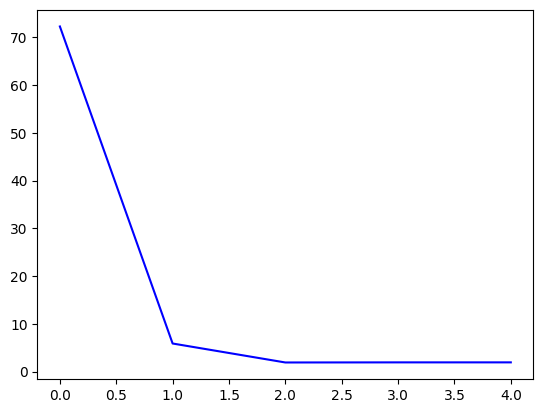

In [35]:
from matplotlib import pyplot as plt 


plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')

In [36]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():  # We don't need gradients for evaluation
        for images, labels in dataloader:
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Accuracy as a percentage
    return accuracy


In [ ]:
accuracy = calculate_accuracy(mymodel, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')


2530.07s - Error when getting str with custom provider: <pydevd_plugins.extensions.types.pydevd_plugin_pandas_types.PandasDataFrameTypeResolveProvider object at 0x152636a90>.
Traceback (most recent call last):
  File "/opt/miniconda3/envs/cdd203/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_xml.py", line 233, in str_from_providers
    return self._get_str_from_provider(provider, o, context)
  File "/opt/miniconda3/envs/cdd203/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_xml.py", line 215, in _get_str_from_provider
    return provider.get_str(o)
  File "/opt/miniconda3/envs/cdd203/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd_plugins/extensions/types/pydevd_plugin_pandas_types.py", line 117, in get_str
    return repr(df)
  File "/opt/miniconda3/envs/cdd203/lib/python3.8/site-packages/pandas/core/frame.py", line 1094, in __repr__
    return self.to_string(**repr_params)
  File "/opt/miniconda3/envs/cdd203/lib/pytho